In [5]:
from hotgrad.variable import Variable

import torch
from torch import FloatTensor
from torch.autograd import Variable as tVariable
from torch.nn.functional import relu, tanh

from numpy import isclose

import matplotlib.pylab as plt

from dataset_generator import generate_dataset, generate_dataset_aux

import numpy as np


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from hotgrad.functions.layers import Linear
from hotgrad.functions.losses import MSE
from hotgrad.optimizers import SGD

from torch.nn import Linear as tLinear
from torch.nn import MSELoss
from torch.optim.sgd import SGD as tSGD

%matplotlib inline

In [6]:
a = FloatTensor(1, 3).fill_(1)
b = FloatTensor(4, 3).fill_(0)

c = a+b
a.dim()
c


 1  1  1
 1  1  1
 1  1  1
 1  1  1
[torch.FloatTensor of size 4x3]

In [7]:
c.sum(1).unsqueeze(1)


 3
 3
 3
 3
[torch.FloatTensor of size 4x1]

Modules to be tested:

**Operands**:
- <font color=green>add</font>
- <font color=green>sub</font>
- <font color=green>mul</font>
- <font color=green>matmul</font>
- <font color=green>pow</font>
- <font color=green>mean</font>

**Layers**:
- <font color=green>Linear</font>

**Losses**:
- <font color=green>MSE</font>

**Activations**:
- <font color=green>ReLU</font>
- <font color=green>Tanh</font>

**Optimizers**:
- SGD

torch.Size([1000, 2]) torch.Size([1000, 2]) torch.Size([1000, 2]) torch.Size([1000, 2])


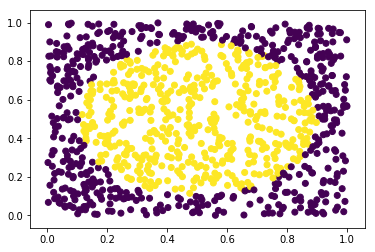

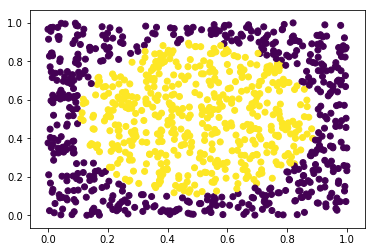

In [10]:
one_hot_encoding=True
X_train, X_test, y_train, y_test = generate_dataset(one_hot_encoding=one_hot_encoding)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

if one_hot_encoding:
    plt.scatter(X_train.data[:, 0], X_train.data[:, 1], c=y_train.data[:, 0])
    plt.show()
    plt.scatter(X_test.data[:, 0], X_test.data[:, 1], c=y_test.data[:, 0])
else:
    plt.scatter(X_train.data[:, 0], X_train.data[:, 1], c=y_train.data)
    plt.show()
    plt.scatter(X_test.data[:, 0], X_test.data[:, 1], c=y_test.data)

### Test logistic regression, NearestNeighbors and random forest

In [ ]:
X_train, X_test, y_train, y_test = generate_dataset(one_hot_encoding=False)

In [ ]:
print("-Logistic regression:")
model = LogisticRegression()
model.fit(X_train.data, y_train.data)
print("\tTrain score:", model.score(X_train.data, y_train.data))
print("\tTest score:", model.score(X_test.data, y_test.data))

print("\n-KMeans:")
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train.data, y_train.data)
print("\tTrain score:", model.score(X_train.data, y_train.data))
print("\tTest score:", model.score(X_test.data, y_test.data))

print("\n-Random Forest:")
model = RandomForestClassifier()
model.fit(X_train.data, y_train.data)
print("\tTrain score:", model.score(X_train.data, y_train.data))
print("\tTest score:", model.score(X_test.data, y_test.data))

### Test 2D

In [ ]:
def chain(var1, var2, var3, var4, var5):
    temp = (var1.pow(2) + var2 - var3 - var3).pow(3)
    
    if isinstance(var1, Variable):
        temp = temp.relu()
    else:
        temp = relu(temp)
    temp = ((temp*var1) @ var4) - var5

    if isinstance(var1, Variable):
        temp = temp.tanh()
    else:
        temp = tanh(temp)

    temp = ((temp + var5) * var5).pow(3)
    return temp.mean()

max_ = 10
n_tests = 10

correct = True
for i in range(n_tests):
    dim1 = np.random.randint(1, max_)
    dim2 = np.random.randint(1, max_)
    dim3 = np.random.randint(1, max_)

    var1 = FloatTensor(dim1, dim2).uniform_(-100, 100) 
    var2 = FloatTensor(dim1, dim2).uniform_(-100, 100) 
    var3 = FloatTensor(dim1, dim2).uniform_(-100, 100) 
    var4 = FloatTensor(dim2, dim3).uniform_(-100, 100) 
    var5 = FloatTensor(dim1, dim3).uniform_(-100, 100) 

    a, b, c, d, e = Variable(var1, requires_grad=True), Variable(var2, requires_grad=True), Variable(var3, requires_grad=True), Variable(var4, requires_grad=True), Variable(var5, requires_grad=True)
    res = chain(a, b, c, d, e)

    ta, tb, tc, td, te = tVariable(var1, requires_grad=True), tVariable(var2, requires_grad=True), tVariable(var3, requires_grad=True), tVariable(var4, requires_grad=True), tVariable(var5, requires_grad=True)
    tres = chain(ta, tb, tc, td, te)

    res.backward()
    tres.backward()

    correct = correct and isclose(res.data, tres.data, atol=0).all()
    correct = correct and isclose(a.grad, ta.grad.data, atol=0).all()
    correct = correct and isclose(b.grad, tb.grad.data, atol=0).all()
    correct = correct and isclose(c.grad, tc.grad.data, atol=0).all()
    correct = correct and isclose(d.grad, td.grad.data, atol=0).all()
    
    if not correct:
        print("ERROR! :(")
        break
        
if correct:
    print("good boy! :)")

### Test 2D with broadcasting

In [ ]:
x = FloatTensor(2, 4).fill_(1)
y = FloatTensor(2, 1).fill_(2)

a = Variable(x, requires_grad=True)
b = Variable(y, requires_grad=True)
c = (a+b).mean()

ta = tVariable(x, requires_grad=True)
tb = tVariable(y, requires_grad=True)
tc = (ta+tb).mean()

c.backward()
tc.backward()

print((a.grad == ta.grad.data).all())
print((b.grad == tb.grad.data).all())

In [ ]:
def chain(var1, var2, var3, var4, var5):
    temp = (var1.pow(2) + var2 - var3 - var3).pow(3)
    
    if isinstance(var1, Variable):
        temp = temp.relu()
    else:
        temp = relu(temp)
    temp = ((temp*var1) @ var4) - var5

    if isinstance(var1, Variable):
        temp = temp.tanh()
    else:
        temp = tanh(temp)

    temp = ((temp + var5) * var5).pow(3)
    return temp.mean()

max_ = 10
n_tests = 10

correct = True
for i in range(n_tests):
    dim1 = np.random.randint(1, max_)
    dim2 = np.random.randint(1, max_)
    dim3 = np.random.randint(1, max_)

    var1 = FloatTensor(dim1, 1).uniform_(-100, 100) 
    var2 = FloatTensor(dim1, dim2).uniform_(-100, 100) 
    var3 = FloatTensor(1, dim2).uniform_(-100, 100) 
    var4 = FloatTensor(dim2, dim3).uniform_(-100, 100) 
    var5 = FloatTensor(dim1, 1).uniform_(-100, 100) 

    a, b, c, d, e = Variable(var1, requires_grad=True), Variable(var2, requires_grad=True), Variable(var3, requires_grad=True), Variable(var4, requires_grad=True), Variable(var5, requires_grad=True)
    res = chain(a, b, c, d, e)

    ta, tb, tc, td, te = tVariable(var1, requires_grad=True), tVariable(var2, requires_grad=True), tVariable(var3, requires_grad=True), tVariable(var4, requires_grad=True), tVariable(var5, requires_grad=True)
    tres = chain(ta, tb, tc, td, te)

    res.backward()
    tres.backward()

    correct = correct and isclose(res.data, tres.data, atol=0).all()
    correct = correct and isclose(a.grad, ta.grad.data, atol=0).all()
    correct = correct and isclose(b.grad, tb.grad.data, atol=0).all()
    correct = correct and isclose(c.grad, tc.grad.data, atol=0).all()
    correct = correct and isclose(d.grad, td.grad.data, atol=0).all()
    
    if not correct:
        print("ERROR! :(")
        break
        
if correct:
    print("good boy! :)")

### Test Linear and MSE 

In [ ]:
max_ = 100
dim1 = np.random.randint(1, max_)
dim2 = np.random.randint(1, max_)
dim3 = np.random.randint(1, max_)
dim4 = np.random.randint(1, max_)

var1 = FloatTensor(dim1, dim2).uniform_(-100, 100) 

target1 = FloatTensor(dim1, dim4).uniform_(-100, 100)

a = Variable(var1, requires_grad=True)
o = Variable(target1)
l1 = Linear(var1.shape[1], dim3)
l2 = Linear(dim3, dim4)
mse = MSE()

ta = tVariable(var1, requires_grad=True)
to = tVariable(target1)
tl1 = tLinear(var1.shape[1], dim3, bias=True)
tl2 = tLinear(dim3, dim4, bias=True)
tmse = MSELoss()

l1.weight.data = tl1.weight.data.t()
l2.weight.data = tl2.weight.data.t()
l1.bias.data[0] = tl1.bias.data
l2.bias.data[0] = tl2.bias.data

res = mse(l2(l1(a)), o)
tres = tmse(tl2(tl1(ta)), to)

res.backward()
tres.backward()

sgd = SGD(lr=0.1)
sgd.set_params(list(l1.params()) + list(l2.params()))
tsgd = tSGD(list(tl1.parameters()) + list(tl2.parameters()), lr=0.1)

before = l1.weight.data.clone()
tbefore = tl1.weight.clone()

sgd.step()
tsgd.step()

print((a.grad == ta.grad.data).all())
# print(isclose(l1.weight.grad, tl1.weight.grad.data.t()).all())
# print(isclose(l2.weight.grad, tl2.weight.grad.data.t()).all())
print(isclose(l1.weight.data, tl1.weight.data.t()).all())
print(isclose(l2.weight.data, tl2.weight.data.t()).all())

In [ ]:
(tl1.weight.data-tbefore.data)/tl1.weight.grad.data, (l1.weight.data-before)/l1.weight.grad

### Test sequential

In [ ]:
from hotgrad.sequential import Sequential
from hotgrad.functions.layers import Linear
from hotgrad.functions.activations import ReLU, Tanh
from hotgrad.functions.losses import MSE
from hotgrad.optimizers import SGD

from dataset_generator import generate_dataset

# generate the dataset
X_train, X_test, y_train, y_test = generate_dataset(1000, one_hot_encoding=True)

# model: two input units, two output units, three hidden layers of 25 units
# model = Sequential([Linear(2,25), ReLU(), Linear(25,25), ReLU(), Linear(25,25), ReLU(), Linear(25,2)], MSE(), SGD(lr=0.01))
model = Sequential([Linear(2,25), Tanh(), Linear(25,25), Tanh(), Linear(25,2), ReLU()], MSE(), SGD(lr=0.01))
                   
# fitting the model
model.fit(X_train, y_train, X_test, y_test, epochs=100)